# Pràctica 3: chinese_mnist

En aquest fitxer es presentara tot el codi utilitzat per fer la comparació dels models i fer una classificació numèrica de la base de dades.

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import os
import matplotlib.image as mpimg

In [182]:
#Mostramos los archivos que tienen solo lectura de la carpeta

for dirname, _, filenames in os.walk('../Practica3APC-GKA06-15D-1330'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../Practica3APC-GKA06-15D-1330\chinese_mnist.csv
../Practica3APC-GKA06-15D-1330\chinese_mnist.ipynb
../Practica3APC-GKA06-15D-1330\chinese_mnist.tfrecords
../Practica3APC-GKA06-15D-1330\README.md
../Practica3APC-GKA06-15D-1330\.git\COMMIT_EDITMSG
../Practica3APC-GKA06-15D-1330\.git\config
../Practica3APC-GKA06-15D-1330\.git\description
../Practica3APC-GKA06-15D-1330\.git\FETCH_HEAD
../Practica3APC-GKA06-15D-1330\.git\HEAD
../Practica3APC-GKA06-15D-1330\.git\index
../Practica3APC-GKA06-15D-1330\.git\ORIG_HEAD
../Practica3APC-GKA06-15D-1330\.git\packed-refs
../Practica3APC-GKA06-15D-1330\.git\hooks\applypatch-msg.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\commit-msg.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\fsmonitor-watchman.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\post-update.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-applypatch.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-commit.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-merge-commit.sa

In [183]:
# Carreguem dataset
dataset = pd.read_csv('chinese_mnist.csv')
print("Dimensionalitat de la BBDD:", dataset.shape)
print("\nTabla de la BBDD:")
display(dataset)

Dimensionalitat de la BBDD: (15000, 5)

Tabla de la BBDD:


,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [184]:
#percentatges nulls
print(dataset.isnull().sum()/len(dataset)*100)

suite_id     0.0
sample_id    0.0
code         0.0
value        0.0
character    0.0
dtype: float64


In [185]:
#caracters de sortida:
sortides = dataset['character'].unique()
print(sortides)

['九' '十' '百' '千' '万' '亿' '零' '一' '二' '三' '四' '五' '六' '七' '八']


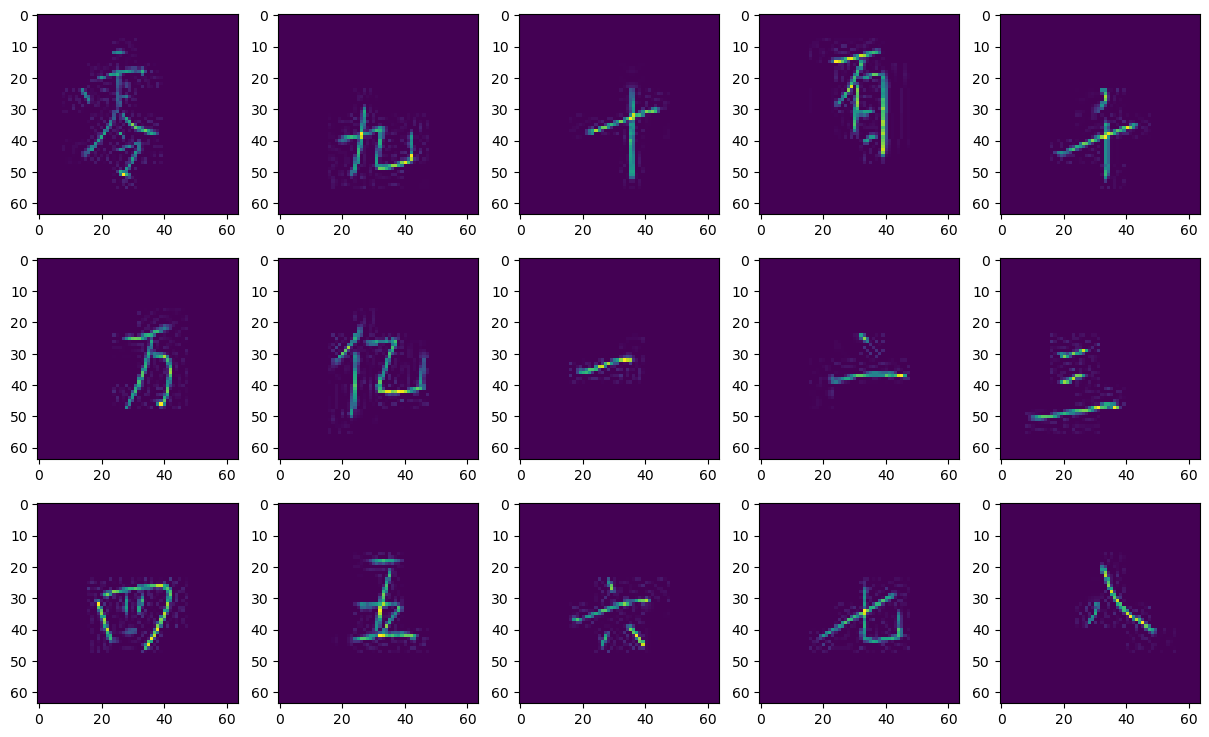

In [186]:
#Mostrar algunas imagenes con pyplot (las 15 primeras)
plt.figure(figsize=(15,9))

carpeta = 'data/data'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:15]):
  plt.subplot(3,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [187]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [188]:
X = []
y = []
for row in dataset.itertuples():
    suite_id = row[1]
    sample_id = row[2]
    code = row[3]
    file_name = f"input_{suite_id}_{sample_id}_{code}.jpg"
    
    #Guarda la imagen
    img = cv2.imread(f"data/data/{file_name}")

    #Convierte a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Aplicamos threshold
    x = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)[1]
    X.append(x)

    #Hacemos one_hot encode
    one_hot = [0] * 15
    one_hot[code - 1] = 1
    y.append(one_hot)

X = np.array(X)

#salida One Hot Encoded
y = np.array(y)

#Salida sin One Hot Encoded
#Salida sin One Hot Encoded
y_n = dataset['value']
x_n = X
#y = dataset['character']

#dataset One Hot Encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#dataset Normal
Xn_train, Xn_test, yn_train, yn_test = train_test_split(x_n, y_n, test_size=0.2, random_state=42)
#XOneHot_train, XOneHot_test, yOneHot_train, yOneHot_test = train_test_split(X, yOneHot, test_size=0.2, random_state=42)


In [189]:
print(Xn_train.shape)
print(yn_train.shape)
print(X_train.shape)
print(y_train.shape)

(12000, 64, 64)
(12000,)
(12000, 64, 64)
(12000, 15)


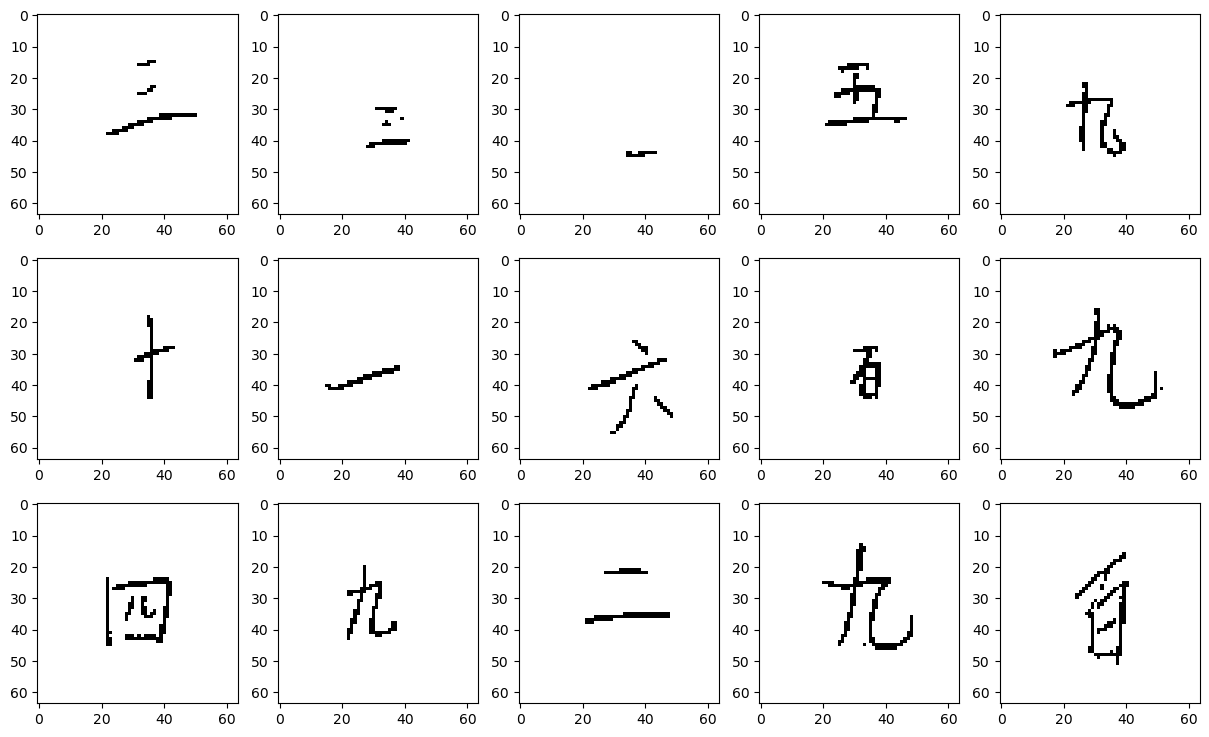

In [190]:
plt.figure(figsize=(15,9))
for i, imagen in enumerate(X_train[:15]):
    plt.subplot(3, 5,i+1)
    #Imprimim en blanc i negre
    #plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.imshow(imagen, cmap = plt.cm.binary)

In [191]:
#clase Callback para limitante
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## Funcio per representar graficament els resultats:

In [192]:
class_names = dataset['character'].unique()

def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    index = np.where(true_label == 1)[0][0]
    #index += 1
    #print(index)
    predicted_label = np.argmax(predictions_array)
    #print(predicted_label)
    if predicted_label == index:
        color = 'blue'
    else:
        color = 'red'
    #print(class_names[predicted_label])
    plt.xlabel(f"Prediccion: {predicted_label}", color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    #print(predictions_array.max())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(15), predictions_array, color="#888888")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    index = np.where(true_label == 1)[0][0]
    
    thisplot[predicted_label].set_color('red')
    thisplot[index].set_color('blue')

# Obtenemos las predicciones del modelo utilizando X_test como entrada

def tablaAciertos(predictions, labels, imatges):
    #print(X_test[0].shape)
    numrows=5
    numcols=3
    numimages = numrows*numcols

    plt.figure(figsize=(2*2*numcols, 2*numrows))

    # Iteramos sobre las primeras 15 imágenes y etiquetas de X_test y y_test
    for i in range(15):
      plt.subplot(numrows, 2*numcols, 2*i+1)
      plot_image(i, predictions, labels, imatges)
      plt.subplot(numrows, 2*numcols, 2*i+2)
      plot_value_array(i, predictions, labels)

    plt.show()

## Modelos Redes Neuronales con dataset **Sin One hot Encode**
Primero creare todas las redes neuronales con unas 50 neuronas para comparar las diferentes perdidas, modelos etc.
Debido a que mientras mas neuronas, mas capas ocultas mas tarda, por eso los parametros decididos son:

-Una capa de neuronas de entrada tipo Flatten
-Una capa densa de 50 neuronas
-Una capa densa de salida

Los parametros decididos para el entrenamiento inicial son:

  -50 Epocas



In [214]:
from tensorflow.python import metrics
#Modelo con funcion de costo Error Cuadratico Medio (MSE)
mseModel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50), #neuronas de entrada
    tf.keras.layers.Dense(1), #neuronas de entrada
])
#Compilar el modelo
mseModel.compile(    
    optimizer = 'adam',
    loss='mean_squared_error',
    metrics = ['accuracy']
)
mseModel.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE)

mapeModel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50), #neuronas de entrada
    tf.keras.layers.Dense(1), #neuronas de entrada
])
#Compilar el modelo
mapeModel.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    metrics = ['accuracy']
)
mapeModel.summary()

#Modelo con funcion de costo categorical_crossentropy

cceModel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50), #neuronas de entrada
    tf.keras.layers.Dense(1), #neuronas de entrada
])
#Compilar el modelo
cceModel.compile(    
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cceModel.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE)

maeModel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50), #neuronas de entrada
    tf.keras.layers.Dense(1), #neuronas de entrada
])
#Compilar el modelo
maeModel.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics = ['accuracy']
)
maeModel.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_66 (Flatten)        (None, 4096)              0         
                                                                 
 dense_141 (Dense)           (None, 50)                204850    
                                                                 
 dense_142 (Dense)           (None, 1)                 51        
                                                                 
Total params: 204,901
Trainable params: 204,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_67 (Flatten)        (None, 4096)              0         
                                                                 
 dense_143 (Dense)      

In [215]:
#print(Xn_train.shape)
historialMSE = mseModel.fit(Xn_train, yn_train, epochs=50, verbose=False)


In [216]:
historialMAPE = mapeModel.fit(Xn_train, yn_train, epochs=50, verbose=False)

In [217]:
historialCCE = cceModel.fit(Xn_train, yn_train, epochs=50, verbose=False)

In [218]:
historialMAE = maeModel.fit(Xn_train, yn_train, epochs=50, verbose=False)

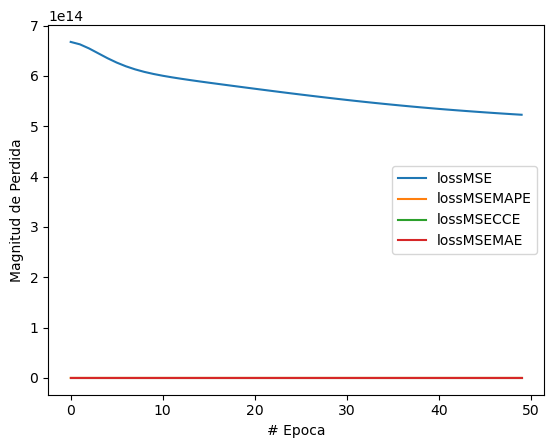

In [223]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')

plt.plot(historialMSE.history['loss'],label='lossMSE')
plt.plot(historialMAPE.history['loss'],label='lossMSEMAPE')
plt.plot(historialCCE.history['loss'],label='lossMSECCE')
plt.plot(historialMAE.history['loss'],label='lossMSEMAE')
plt.legend()

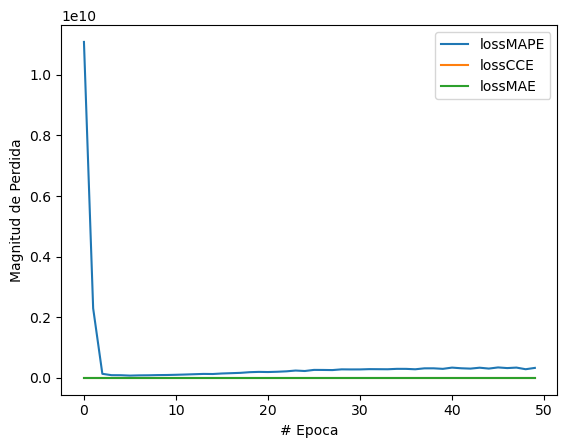

In [224]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')

#plt.plot(historialMSE.history['loss'],label='historialMSE')
plt.plot(historialMAPE.history['loss'],label='lossMAPE')
plt.plot(historialCCE.history['loss'],label='lossCCE')
plt.plot(historialMAE.history['loss'],label='lossMAE')
plt.legend()

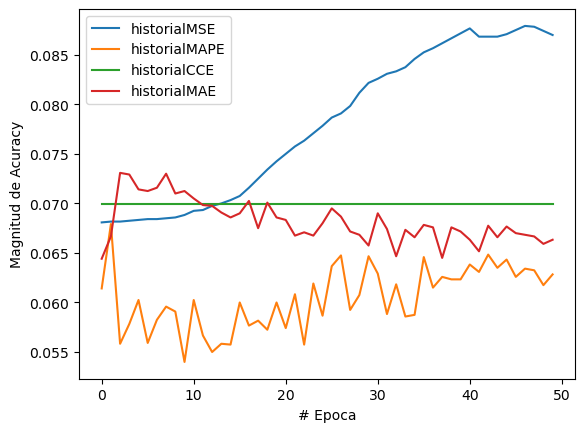

In [221]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Acuracy')

plt.plot(historialMSE.history['accuracy'],label='historialMSE')
plt.plot(historialMAPE.history['accuracy'],label='historialMAPE')
plt.plot(historialCCE.history['accuracy'],label='historialCCE')
plt.plot(historialMAE.history['accuracy'],label='historialMAE')
plt.legend()

In [222]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas MSE: ")
test_loss, test_accuracy = mseModel.evaluate(
    Xn_test, yn_test,verbose=2)

#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAPE: ")
test_loss, test_accuracy = mapeModel.evaluate(
    Xn_test, yn_test,verbose=2)



#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE: ")
test_loss, test_accuracy = cceModel.evaluate(
    Xn_test, yn_test,verbose=2)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAE: ", test_accuracy)
test_loss, test_accuracy = maeModel.evaluate(
    Xn_test, yn_test,verbose=2)




Resultado en las pruebas MSE: 
94/94 - 0s - loss: 532647214317568.0000 - accuracy: 0.0790 - 224ms/epoch - 2ms/step
Resultado en las pruebas MAPE: 
94/94 - 0s - loss: 237110688.0000 - accuracy: 0.0600 - 322ms/epoch - 3ms/step
Resultado en las pruebas CCE: 
94/94 - 0s - loss: 0.7869 - accuracy: 0.0637 - 356ms/epoch - 4ms/step
Resultado en las pruebas MAE:  0.06366666406393051
94/94 - 0s - loss: 6600810.5000 - accuracy: 0.0697 - 365ms/epoch - 4ms/step


## Modelos Redes Neuronales con dataset **Con One hot Encode**
Primero creare todas las redes neuronales con unas *50* neuronas para comparar las diferentes perdidas, modelos etc.
Debido a que mientras mas neuronas, mas capas ocultas mas tarda, por eso los parametros decididos son:

-Una capa de neuronas de entrada tipo Flatten
-Una capa densa de 128 neuronas
-Una capa densa de salida

Los parametros decididos para el entrenamiento inicial son:

  -50 Epocas


In [226]:
from tensorflow.python import metrics
#Modelo con funcion de costo Error Cuadratico Medio (MSE) One Hot Encoded (OHE)
mseModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
mseModelOHE.compile(    
    optimizer = 'adam',
    loss='mean_squared_error',
    metrics = ['accuracy']
)
mseModelOHE.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE) One Hot Encoded (OHE)

mapeModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
mapeModelOHE.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    metrics = ['accuracy']
)
mapeModelOHE.summary()

#Modelo con funcion de costo categorical_crossentropy One Hot Encoded (OHE)

cceModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
cceModelOHE.compile(    
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cceModelOHE.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE) One Hot Encoded (OHE)

maeModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
maeModelOHE.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics = ['accuracy']
)
maeModelOHE.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_74 (Flatten)        (None, 4096)              0         
                                                                 
 dense_157 (Dense)           (None, 50)                204850    
                                                                 
 dense_158 (Dense)           (None, 15)                765       
                                                                 
Total params: 205,615
Trainable params: 205,615
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_75 (Flatten)        (None, 4096)              0         
                                                                 
 dense_159 (Dense)      

In [227]:
historialMSEOHE = mseModelOHE.fit(X_train, y_train, epochs=50, verbose=False)

In [228]:
historialMAPEOHE = mapeModelOHE.fit(X_train, y_train, epochs=50, verbose=False)

In [229]:
historialCCEOHE = cceModelOHE.fit(X_train, y_train, epochs=50, verbose=False)

In [230]:
historialMAEOHE = maeModelOHE.fit(X_train, y_train, epochs=50, verbose=False)

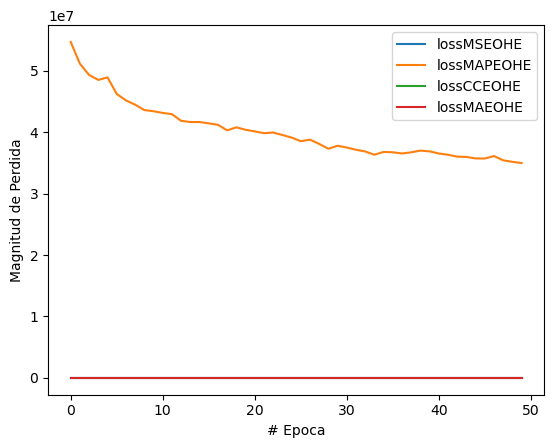

In [231]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')

plt.plot(historialMSEOHE.history['loss'],label='lossMSEOHE')
plt.plot(historialMAPEOHE.history['loss'],label='lossMAPEOHE')
plt.plot(historialCCEOHE.history['loss'],label='lossCCEOHE')
plt.plot(historialMAEOHE.history['loss'],label='lossMAEOHE')
plt.legend()

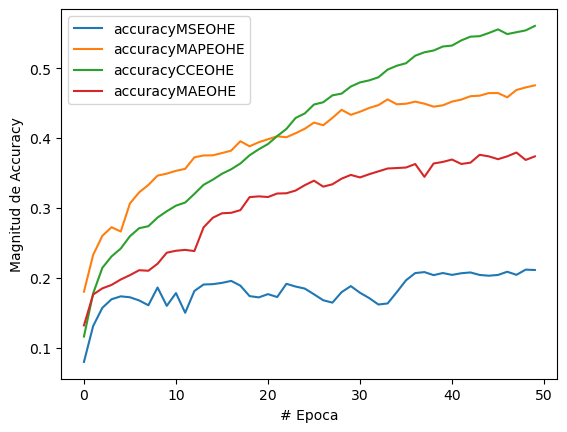

In [232]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Accuracy')

plt.plot(historialMSEOHE.history['accuracy'],label='accuracyMSEOHE')
plt.plot(historialMAPEOHE.history['accuracy'],label='accuracyMAPEOHE')
plt.plot(historialCCEOHE.history['accuracy'],label='accuracyCCEOHE')
plt.plot(historialMAEOHE.history['accuracy'],label='accuracyMAEOHE')
plt.legend()

In [234]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas MSE con OHE: ")
test_loss, test_accuracy = mseModelOHE.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAPE con OHE: ")

test_loss, test_accuracy = mapeModelOHE.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE con OHE: ")
test_loss, test_accuracy = cceModelOHE.evaluate(X_test, y_test)

#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAE con OHE: ")
test_loss, test_accuracy = maeModelOHE.evaluate(X_test, y_test)




Resultado en las pruebas MSE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.1897
Resultado en las pruebas MAPE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 38208112.0000 - accuracy: 0.4270
Resultado en las pruebas CCE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 2.4464 - accuracy: 0.4367
Resultado en las pruebas MAE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.3443


## Comparacion de modelos

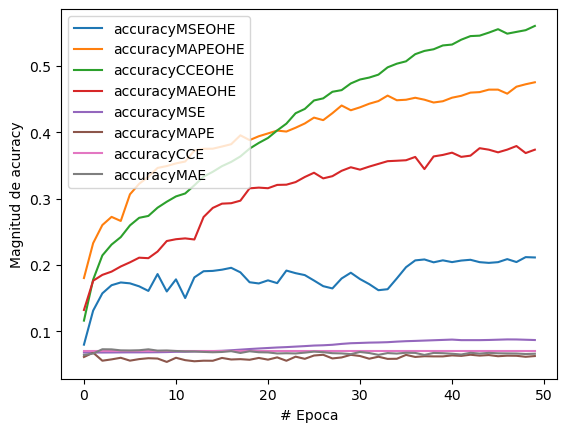

In [236]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de acuracy')

plt.plot(historialMSEOHE.history['accuracy'],label='accuracyMSEOHE')
plt.plot(historialMAPEOHE.history['accuracy'],label='accuracyMAPEOHE')
plt.plot(historialCCEOHE.history['accuracy'],label='accuracyCCEOHE')
plt.plot(historialMAEOHE.history['accuracy'],label='accuracyMAEOHE')
plt.plot(historialMSE.history['accuracy'],label='accuracyMSE')
plt.plot(historialMAPE.history['accuracy'],label='accuracyMAPE')
plt.plot(historialCCE.history['accuracy'],label='accuracyCCE')
plt.plot(historialMAE.history['accuracy'],label='accuracyMAE')
plt.legend()

Como se puede observar, el modelo sin One Hot Encoder tiene un acuracy que da pena, y de los otros modelos el mejor es el CCE con OHE, como se puede ver en la grafica (color verde)

In [238]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas MSE: ")
test_loss, test_accuracy = mseModel.evaluate(
    Xn_test, yn_test,verbose=2)

#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAPE: ")
test_loss, test_accuracy = mapeModel.evaluate(
    Xn_test, yn_test,verbose=2)



#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE: ")
test_loss, test_accuracy = cceModel.evaluate(
    Xn_test, yn_test,verbose=2)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAE: ", test_accuracy)
test_loss, test_accuracy = maeModel.evaluate(
    Xn_test, yn_test,verbose=2)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas MSE con OHE: ")
test_loss, test_accuracy = mseModelOHE.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAPE con OHE: ")

test_loss, test_accuracy = mapeModelOHE.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE con OHE: ")
test_loss, test_accuracy = cceModelOHE.evaluate(X_test, y_test)

#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAE con OHE: ")
test_loss, test_accuracy = maeModelOHE.evaluate(X_test, y_test)




Resultado en las pruebas MSE: 
94/94 - 0s - loss: 532647214317568.0000 - accuracy: 0.0790 - 112ms/epoch - 1ms/step
Resultado en las pruebas MAPE: 
94/94 - 0s - loss: 237110688.0000 - accuracy: 0.0600 - 143ms/epoch - 2ms/step
Resultado en las pruebas CCE: 
94/94 - 0s - loss: 0.7869 - accuracy: 0.0637 - 120ms/epoch - 1ms/step
Resultado en las pruebas MAE:  0.06366666406393051
94/94 - 0s - loss: 6600810.5000 - accuracy: 0.0697 - 144ms/epoch - 2ms/step
Resultado en las pruebas MSE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.1897
Resultado en las pruebas MAPE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 38208112.0000 - accuracy: 0.4270
Resultado en las pruebas CCE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 2.4464 - accuracy: 0.4367
Resultado en las pruebas MAE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.3443


Por otro lado como se puede observar la mejor accuracy sigue siendo la que usa CCE con OHE

## Mejora modelos

Como hemos observado, el mejor modelo es la red neuronal con una funcion de perdida segun 'categorical_crossentropy', por lo que nos encargaremos de intentar mejorar aun mas las accuracys con mas neuronas por capa, mas capas o otras opciones que ofrece tensor flow

In [258]:
#Crear el modelo, este caso tendra 2 capas de 50 neuronas

cceModelOHE_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
cceModelOHE_1.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cceModelOHE_1.summary()

#Crear el modelo, este caso tendra 1 capa de 128 neuronas

cceModelOHE_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64, 64, 1]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
cceModelOHE_2.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cceModelOHE_2.summary()

#Crear el modelo, este caso tendra 2 capas de 128 neuronas

cceModelOHE_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64, 64, 1]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
cceModelOHE_3.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cceModelOHE_3.summary()

#Crear el modelo, este caso tendra 3 capas de 128 neuronas

cceModelOHE_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64, 64, 1]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
cceModelOHE_4.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cceModelOHE_4.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_90 (Flatten)        (None, 4096)              0         
                                                                 
 dense_201 (Dense)           (None, 50)                204850    
                                                                 
 dense_202 (Dense)           (None, 50)                2550      
                                                                 
 dense_203 (Dense)           (None, 15)                765       
                                                                 
Total params: 208,165
Trainable params: 208,165
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_91 (Flatten)   

In [259]:
historialCCEOHE_1 = cceModelOHE_1.fit(X_train, y_train, epochs = 50, verbose=False)

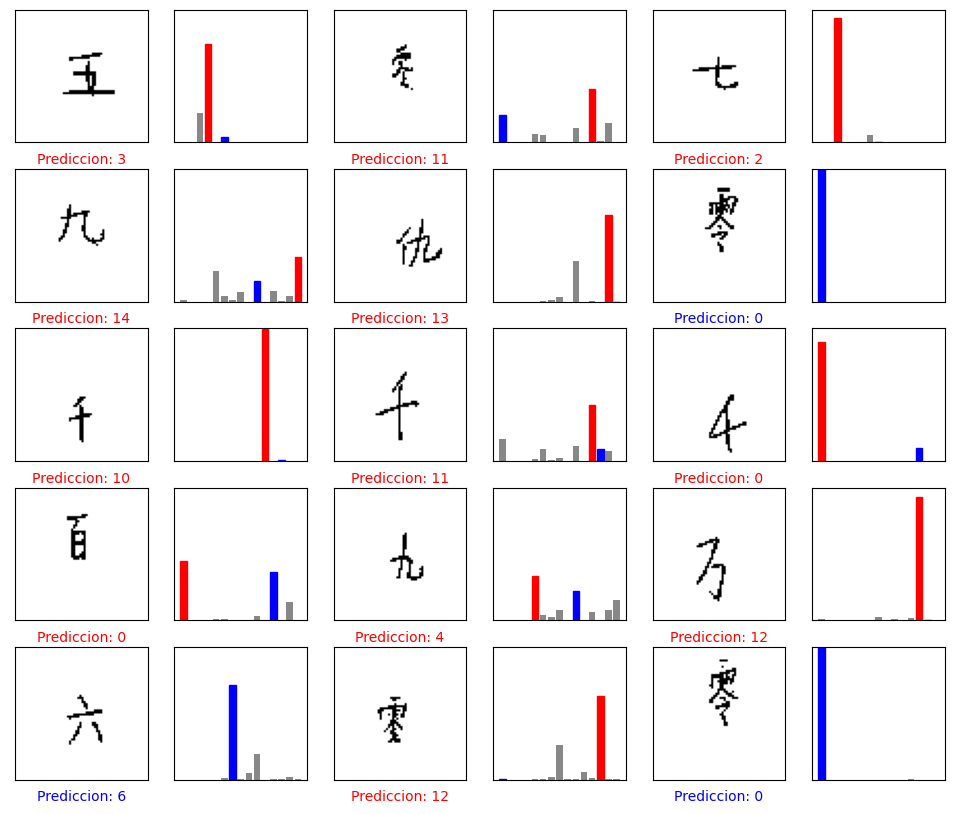

In [260]:
predictions = cceModelOHE_1.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)

In [261]:
historialCCEOHE_2 = cceModelOHE_2.fit(X_train, y_train, epochs = 50, verbose=False)

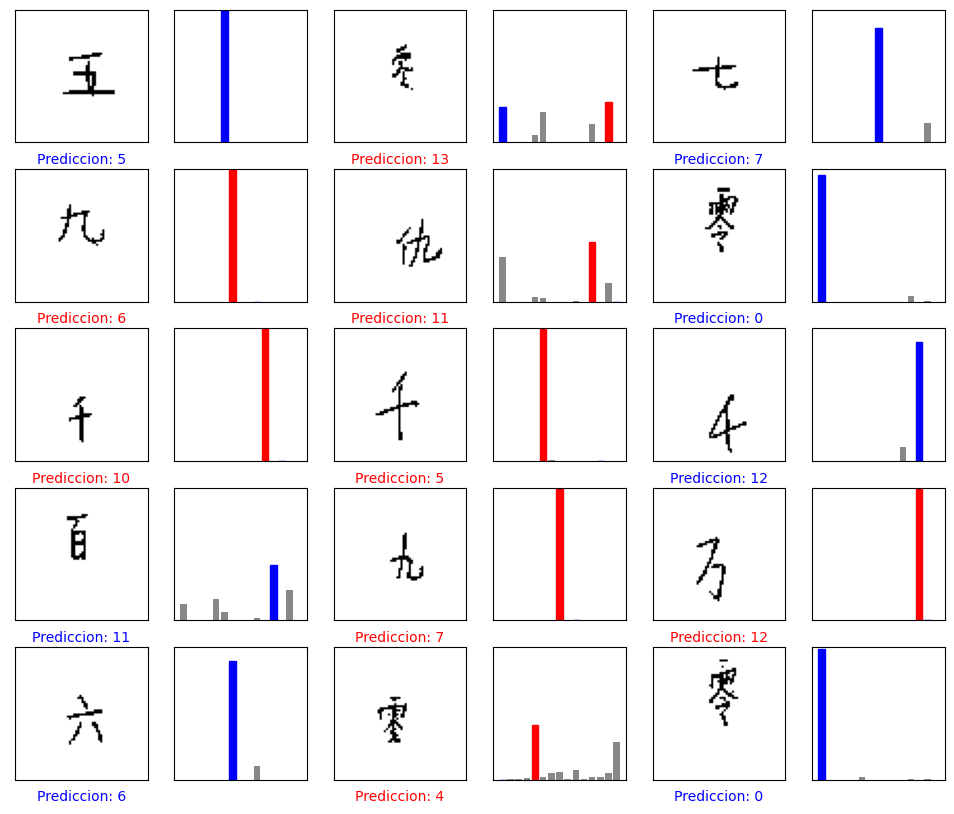

In [262]:
predictions = cceModelOHE_2.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)

In [263]:
historialCCEOHE_3 = cceModelOHE_3.fit(X_train, y_train, epochs = 50, verbose=False)

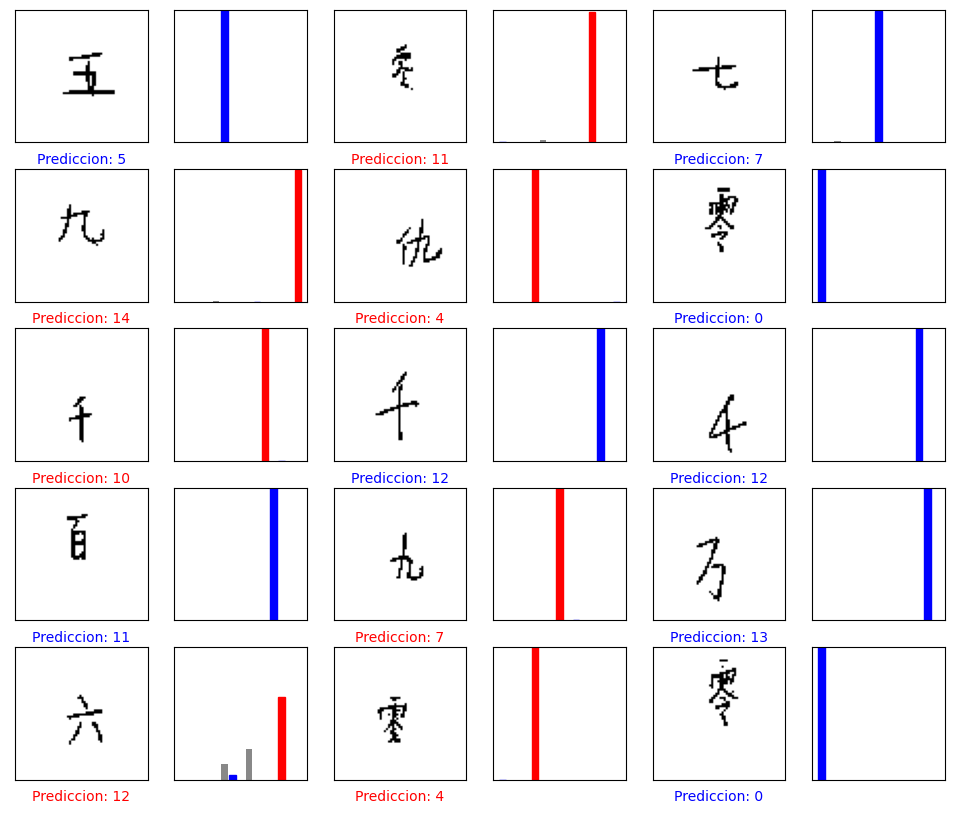

In [264]:
predictions = cceModelOHE_3.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)

In [265]:
historialCCEOHE_4 = cceModelOHE_4.fit(X_train, y_train, epochs = 50, verbose=False)

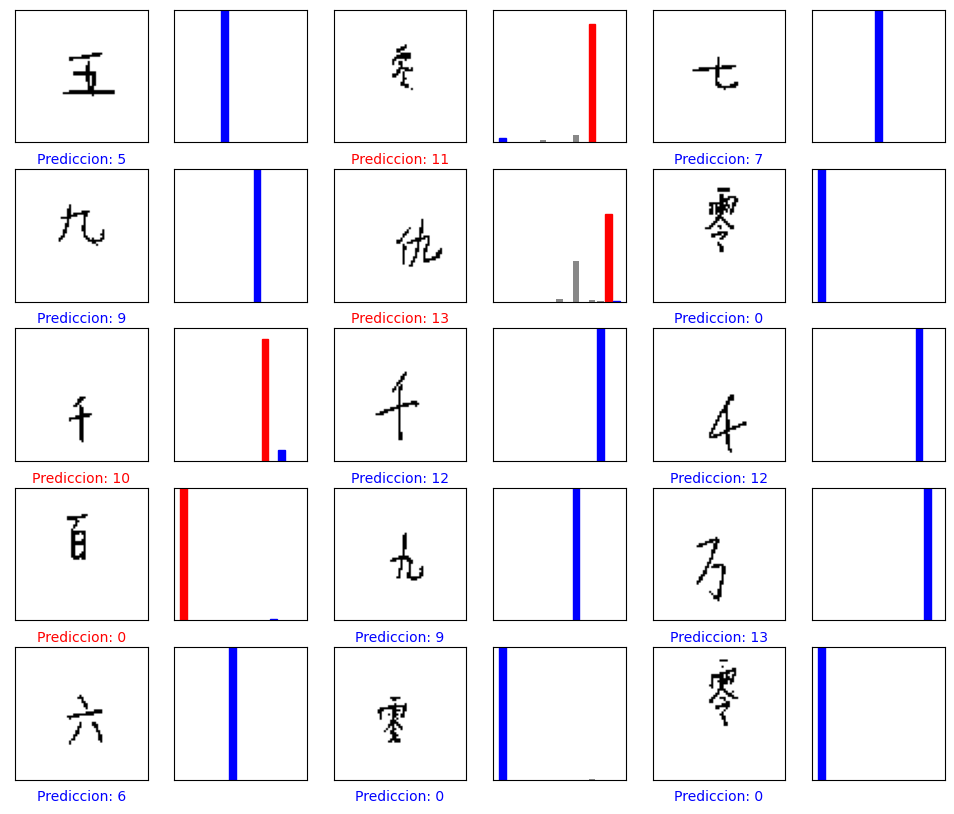

In [266]:
predictions = cceModelOHE_4.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)

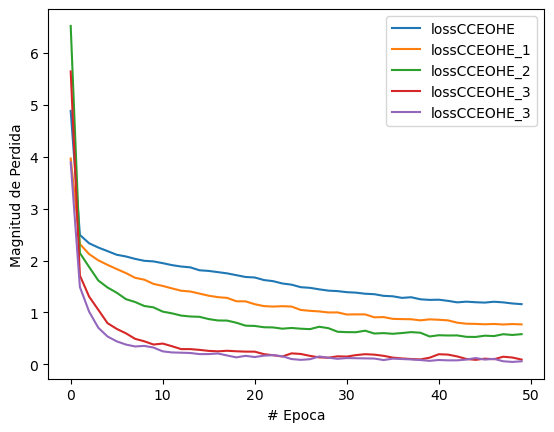

In [267]:
"""XOneHot_train = XOneHot_train.cache()
yOneHot_train = yOneHot_train.cache()
X_train = X_train.cache()
y_train = y_train.cache()


TAMANO_LOTE = 32
X_train = X_train.repeat
X_train = X_train.repeat().shuffle(12000).batch(TAMANO_LOTE)
y_test = y_test.batch(TAMANO_LOTE)"""

plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')


plt.plot(historialCCEOHE.history['loss'],label='lossCCEOHE')
plt.plot(historialCCEOHE_1.history['loss'],label='lossCCEOHE_1')
plt.plot(historialCCEOHE_2.history['loss'],label='lossCCEOHE_2')
plt.plot(historialCCEOHE_3.history['loss'],label='lossCCEOHE_3')
plt.plot(historialCCEOHE_4.history['loss'],label='lossCCEOHE_3')

plt.legend()

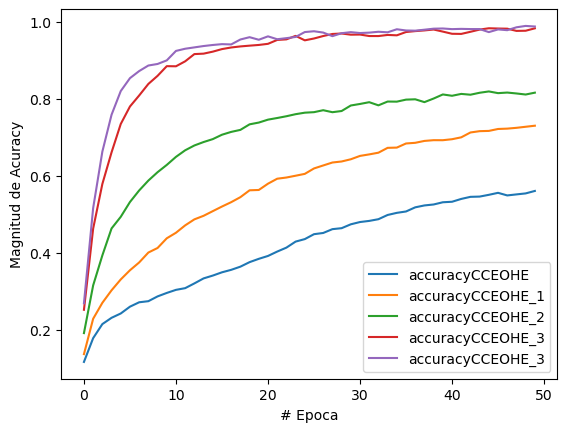

In [268]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Acuracy')


plt.plot(historialCCEOHE.history['accuracy'],label='accuracyCCEOHE')
plt.plot(historialCCEOHE_1.history['accuracy'],label='accuracyCCEOHE_1')
plt.plot(historialCCEOHE_2.history['accuracy'],label='accuracyCCEOHE_2')
plt.plot(historialCCEOHE_3.history['accuracy'],label='accuracyCCEOHE_3')
plt.plot(historialCCEOHE_4.history['accuracy'],label='accuracyCCEOHE_3')

plt.legend()

In [269]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas CCE con OHE: ")
test_loss, test_accuracy = cceModelOHE.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas CCE_1 con OHE: ")
test_loss, test_accuracy = cceModelOHE_1.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE_2 con OHE: ")
test_loss, test_accuracy = cceModelOHE_2.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas CCE_3 con OHE: ")
test_loss, test_accuracy = cceModelOHE_3.evaluate(X_test, y_test)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas CCE_4 con OHE: ")
test_loss, test_accuracy = cceModelOHE_4.evaluate(X_test, y_test)


Resultado en las pruebas CCE con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 2.4464 - accuracy: 0.4367
Resultado en las pruebas CCE_1 con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 2.0936 - accuracy: 0.5073
Resultado en las pruebas CCE_2 con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 3.9700 - accuracy: 0.5933
Resultado en las pruebas CCE_3 con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 4.7133 - accuracy: 0.7320
Resultado en las pruebas CCE_4 con OHE: 
94/94 [==============================] - 0s 2ms/step - loss: 2.3087 - accuracy: 0.7687


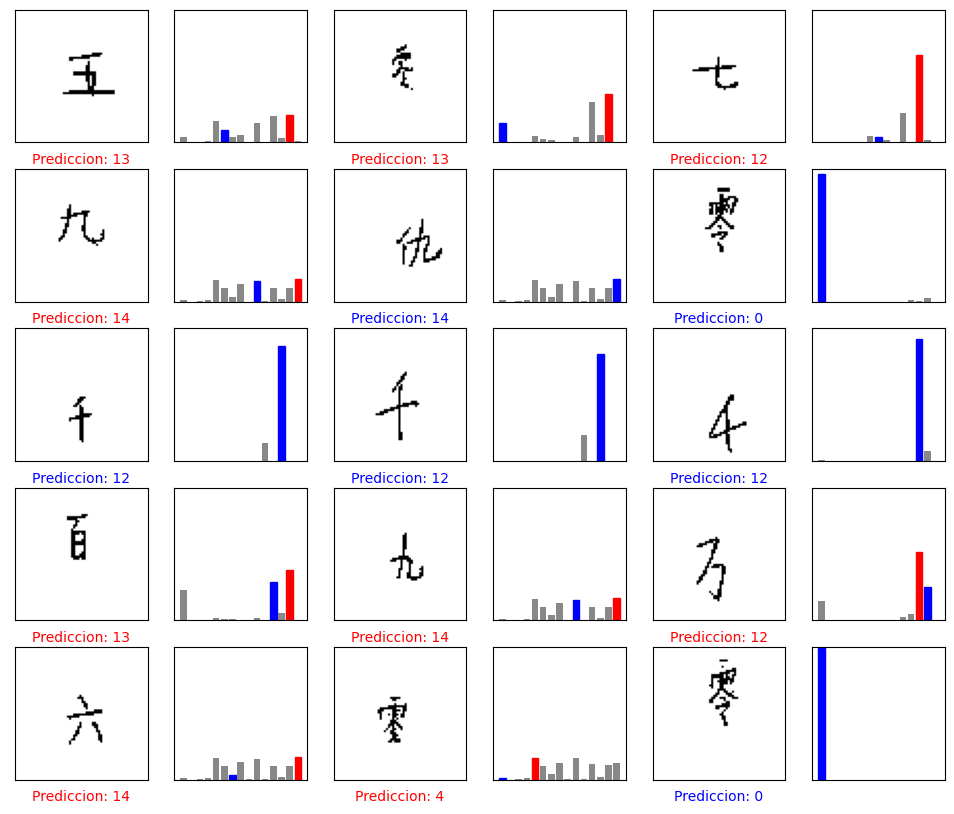

In [270]:

predictions = cceModelOHE.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)

## Red neuronal convolucional

Apartir del mejor modelo mostrado, hare un modelo aplicando una red neuronal convolucional.

In [281]:
#Crear el modelo, este caso tendra 3 capas de 128 neuronas

modelCNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=[64, 64, 1], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),#2,2 es el tamaño de la matriz
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=[64, 64, 1], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),#2,2 es el tamaño de la matriz
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
modelCNN.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
modelCNN.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_98 (Flatten)        (None, 12544)             0         
                                                                 
 dense_225 (Dense)           (None, 128)             

In [ ]:
historialCNN = modelCNN.fit(X_train, y_train, epochs = 50)

Epoch 1/50
375/375 [==============================] - 33s 86ms/step - loss: 1.0598 - accuracy: 0.7280
Epoch 2/50
375/375 [==============================] - 34s 90ms/step - loss: 0.1958 - accuracy: 0.9361
Epoch 3/50
375/375 [==============================] - 34s 91ms/step - loss: 0.1078 - accuracy: 0.9652
Epoch 4/50
375/375 [==============================] - 31s 83ms/step - loss: 0.0769 - accuracy: 0.9751
Epoch 5/50
375/375 [==============================] - 32s 85ms/step - loss: 0.0740 - accuracy: 0.9762
Epoch 6/50
375/375 [==============================] - 34s 90ms/step - loss: 0.0786 - accuracy: 0.9757
Epoch 7/50
375/375 [==============================] - 33s 87ms/step - loss: 0.0627 - accuracy: 0.9812
Epoch 8/50
375/375 [==============================] - 37s 98ms/step - loss: 0.0490 - accuracy: 0.9852
Epoch 9/50
375/375 [==============================] - 38s 101ms/step - loss: 0.0472 - accuracy: 0.9871
Epoch 10/50
375/375 [==============================] - 35s 92ms/step - loss: 0.03

In [ ]:
predictions = modelCNN.predict(X_test, verbose=False)
tablaAciertos(predictions, y_test, X_test)